<br><h1>A2 Report - Classification Modeling Case Study </h1>
<h2>Machine Learning - DAT-5303 - FMSBA3 </h2>
By: Sophie Briques<br>
Hult International Business School<br>
Sunday, March 15th, 2019 <br><br><br>

***

### Overview

- Our best performing model was a Decision Tree with 21 features with a test score of 0.9058
- Optimal features were found using exploratory data analysis, domain knowledge and tree classifiers
- It is predicting whether or not a customer will subscribe to the new service Halfway There.
- Its precision in correctly predicting a new customer is 96%

***

<strong> Case: Apprentice Chef, Inc. </strong> <br>
<i> Audience: Top Executives </i> <br><br>
<strong> Context: </strong> <i> Halfway There </i>, new subscription where customers can receive a half bottle of wine from a local California vineyard every Wednesday. <br>
<strong> Goal: </strong> when promoting this service to a wider audience, know which customers will subscribe to <i> Halfway There </i> <br>
<strong> Target consumer: </strong> busy professional, little to no skills in the kitchen <br>
<strong> Product: </strong> daily-prepared gourmet meals delivered <br>
<strong> Channels: </strong> online platform and mobile app <br> 
<strong> Revenue: </strong> 90% of revenue comes from customers that have been ordering for 12 months or less


<br> General Product Specifications: 
- at most 30 min to finish cooking
- disposable cookware
- delicious and healthy eating<br>

<br> Halfway There Specifications:
- hard to find local wines
- customer need to include government ID in application process to order
<br>
Channels: online platform and mobile app
Revenue: 90% of revenue comes from customers that have been ordering for 12 months or less





***
<strong> Data and Assumptions </strong> <br>
Dataset:
<br> 2,000 customers (approx.)
- at least one purchase per month for a total of 11 of their first 12 months
- at least one purchase per quarter and at least 15 purchases through their first year
- dataset engineering techniques are statistically sound and represent the customers


Assumptions:
- all average times are in seconds
- revenue = price x quantity and total meals ordered represent quantity
- all customers have included their government ID in the registration process
- price of subscription to halfway there is the average price of half-bottle of wine in the menu
- bottle is delivered on Wednesday regardless if the customer has ordered a meal that day or not
- upon registration, each customer gave a phone number (required for registration) and optionally gave an email address
- each customer was able to set their preferred contact method (optional). If not set, customers will be contacted via SMS if their phone number was mobile, and via a direct sales call if their phone number was a landline.

Data Quality issues:
- cancellations before noon and after noon: dictionary says after noon is after 3pm. Are there 3 hours of data for cancellations missing or is the description in dictionary wrong?

***
<strong> Outline: </strong>
1. Part 1: Exploratory Data Analysis
2. Part 2: Build a machine learning model to predict cross-sell success 
3. Part 3: Evaluating Model 


In [1]:
# importing libraries
import pandas            as pd                       # data science essentials
import numpy             as np
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data viz
import statsmodels.formula.api as smf                # statsmodel regressions
from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression  # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.model_selection import GridSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm

# CART model packages
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import export_graphviz             # exports graphics
from sklearn.externals.six import StringIO           # saves objects in memory
from IPython.display import Image                    # displays on frontend
import pydotplus                                     # interprets dot objects

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# specifying file name
file = "Apprentice_Chef_Dataset.xlsx"

# reading the file into Python
original_df = pd.read_excel(file)
chef_org = original_df.copy()

# Reading data dictionary
chef_description = pd.read_excel('Apprentice_Chef_Data_Dictionary.xlsx')
#chef_description

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


#### User-defined functions

In [2]:
#################################################
##########  User-Defined Functions    ###########
#################################################

##########  Defining function for distribution histograms
def distributions(variable, data, bins = 'fd', kde = False, rug = False):
    """
    This function can be used for continuous or count variables.

    PARAMETERS
    ----------
    variable : str, continuous or count variable
    data     : DataFrame
    bins     : argument for matplotlib hist(), optional. If unspecified, Freedman–Diaconis rule is used.
    kde      : bool, optional, plot or not a kernel density estimate.  If unspecified, not calculated.
    rug      : bool, optional, include a rug on plot or not. If unspecified, not shown.
    """
    
    sns.distplot(data[variable],  
                    bins  = bins,
                    kde   = False,
                    rug   = rug)
    
    plt.xlabel(variable)
    plt.tight_layout()
    plt.show()
    
##########  Defining function to flag high outliers in variables
def outlier_flag_hi(variable, threshold, data):
    """
    This function is used to flag high outliers in a dataframe the variables' 
    outliers by creating a new column that is preceded by 'out_'.

    PARAMETERS
    ----------
    variable  : str, continuous variable.
    threshold : float, value that will identify where outliers would be.
    data      : dataframe, where the variables are located.
    
    """
    # creating a new column
    data['out_' + variable + '_hi'] = 0
        
    # defining outlier condition
    high = data.loc[0:,'out_' + variable + '_hi'][data[variable] > threshold]
        
    # imputing 1 inside flag column
    data['out_' + variable + '_hi'].replace(to_replace = high,
                                    value   = 1,
                                    inplace = True)

    


##########  Defining function to flag high outliers in variables
def outlier_flag_lo(variable, threshold, data):
    """
    This function is used to flag low outliers in a dataframe the variables' 
    outliers by creating a new column that is preceded by 'out_'.

    PARAMETERS
    ----------
    variable  : str, continuous variable.
    threshold : float, value that will identify where outliers would be.
    data      : dataframe, where the variables are located.
    
    """
    # creating a new column
    data['out_' + variable + '_lo'] = 0
        
    # defining outlier condition
    low = data.loc[0:,'out_' + variable + '_lo'][data[variable] < threshold]
        
    # imputing 1 inside flag column
    data['out_' + variable + '_lo'].replace(to_replace = low,
                                    value   = 1,
                                    inplace = True)
    

##########  Defining function to plot relationships with categorical response variable
def trend_boxplots(cont_var, response, data):
    """
    This function can be used for categorical variables as target and 
    continuous variables as explanatory.

    PARAMETERS
    ----------
    cont_var : str, explanatory variable
    response : str, response categorical variable
    data     : DataFrame of the response and explanatory variables
    """

    data.boxplot(column       = cont_var,
                 by           = response,
                 vert         = True,
                 patch_artist = False,
                 meanline     = True,
                 showmeans    = True)
    
    plt.grid(b=True, which='both', linestyle='-')
    plt.suptitle("")
    plt.show()
    
    
# Defining function to flag higher variables
def success_flag(variable, threshold, data):
    """
    This function is used to flag in a dataframe the variables' trend changes 
    above a threshold by creating a new column that is preceded by 'success_'.

    PARAMETERS
    ----------
    variable  : str, continuous variable.
    threshold : float, value that will identify after which the trend on variable y changes
    data      : dataframe, where the variables are located.
    
    """
    new_column = 'success_' + variable
    
    # creating a new column
    data[new_column] = 0
        
    # defining outlier condition
    high = data.loc[0:,new_column][data[variable] > threshold]
        
    # imputing 1 inside flag column
    data[new_column].replace(to_replace = high,
                             value   = 1,
                             inplace = True)
    
#Defining a function to standardize numerical variables in the dataset:
def standard(num_df):
    """
    This function standardizes a dataframe that contains variables which are either
    integers or floats.
    
    ------
    num_df : DataFrame, must contain only numerical variables
    
    """
    # INSTANTIATING a StandardScaler() object
    scaler = StandardScaler()

    # FITTING the scaler with housing_data
    scaler.fit(num_df)

    # TRANSFORMING our data after fit
    X_scaled = scaler.transform(num_df)

    # converting scaled data into a DataFrame
    X_scaled_df = pd.DataFrame(X_scaled)
    
    # adding labels to the scaled DataFrame
    X_scaled_df.columns = num_df.columns
    
    # Re-attaching target variable to DataFrame
    #X_scaled_df = X_scaled_df.join(target_variable)
    
    # returning the standardized data frame into the global environment
    return X_scaled_df

# defining a function to find optimal number of neighbors in KNN
def optimal_neighbors(criteria, X_train, y_train, X_test, y_test, max_neighbors):
    """
    This function calculates and returns the optimal number of neighbors for a 
    KNN classifier the optimal number of neighbors given a training, testing, 
    a random seed and max. Should only be used with standardized data.
    
    ----
    criteria      : str, score to which return the optimal number of neighbors.
                        'accuracy', 'auc'
    X_train       : set of explanatory training data
    y_train       : set of target training data
    X_test.       : set of explanatory testing data
    y_test        : set of target testing data
    max_neighbors : maximum number of neighbors to be tested
    """
    # creating empty lists for training set accuracy, test set accuracy and AUC
    training_accuracy = []
    test_accuracy     = []
    auc_score         = []
    
    neighbors_settings = range(1, max_neighbors)
    
    for n_neighbors in neighbors_settings:
        #Building Model
        clf = KNeighborsClassifier(n_neighbors = n_neighbors)
        clf.fit(X_train, y_train.values.reshape(-1,))
        clf_pred = clf.predict(X_test)
        
        # Recording scores
        training_accuracy.append(clf.score(X_train,y_train))
        test_accuracy.append(clf.score(X_test,y_test))
        auc_score.append(roc_auc_score(y_true = y_test,
                                       y_score = clf_pred))
    
    opt_neighbors_accuracy = test_accuracy.index(max(test_accuracy)) + 1
    opt_neighbors_auc      = auc_score.index(max(auc_score)) + 1
    #returning the optimal number of neighbors
    if criteria == 'accuracy':
        return opt_neighbors_accuracy
    elif criteria == 'auc':
        return opt_neighbors_auc
    else:
        print("""Error: criteria specified not available. Argument can only take 'accuracy' or 'auc' """)

# classification confusion matrix
def visual_cm(true_y, pred_y, labels = None, title = 'Confusion Matrix of the Classifier'):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
titel  : str, title of confusion matrix, default: 'Confusion Matrix of the Classifier'
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

<strong> Observations: </strong>
- Data types are coherent with each variable description
- 47 missing values in Family Name
- Number of observations: 1946
- Total of 28 variables (including target variable) where:
    - 3 are floats
    - 22 are integers
    - 4 are objects

***
***

## Part 1: Exploratory Data Analysis (EDA)

In this section, our objective is too understand the data and identify possible insights that will be useful for business application. We'll also go through feature engineering (creating new variables) were we deem appropriate.
<br> <br>
For this purpose, it is important to identify the different variable types in our model:

In [3]:
# Defining lists for each type of variable:
categorical = ['CROSS_SELL_SUCCESS',     # (target variable - binary)
               'MOBILE_NUMBER',          # (also binary)
               'TASTES_AND_PREFERENCES', # (also binary)
               'PACKAGE_LOCKER',         # (also binary)
               'REFRIGERATED_LOCKER']    # (also binary)

continuous = ['REVENUE',
              'AVG_TIME_PER_SITE_VISIT',
              'FOLLOWED_RECOMMENDATIONS_PCT',
              'AVG_PREP_VID_TIME',
              'MEDIAN_MEAL_RATING',]     # (interval)

counts = ['TOTAL_MEALS_ORDERED',
          'UNIQUE_MEALS_PURCH',
          'CONTACTS_W_CUSTOMER_SERVICE',
          'PRODUCT_CATEGORIES_VIEWED',
          'CANCELLATIONS_BEFORE_NOON',
          'CANCELLATIONS_AFTER_NOON',
          'MOBILE_LOGINS',
          'PC_LOGINS',
          'WEEKLY_PLAN',
          'EARLY_DELIVERIES',
          'LATE_DELIVERIES',
          'MASTER_CLASSES_ATTENDED',
          'TOTAL_PHOTOS_VIEWED',
          'LARGEST_ORDER_SIZE',
          'AVG_CLICKS_PER_VISIT']

### A) Anomaly Detection: Missing Values

<strong> Purpose: </strong> Identify and create a strategy for missing values.
***
Missing values can affect our model and our ability to create plots to identify other features in our data.

In [4]:
# Inspecting missing values
#chef_org.isnull().sum()
#chef_org.loc[:,:][chef_org['FAMILY_NAME'].isna()]

# Flagging missing variables for FAMILY_NAME
# creating a copy of dataframe for safety measures
chef_m = chef_org.copy()

# creating a new column where 1 indicates that observation has a missing family name
chef_m['m_FAMILY_NAME'] = chef_m['FAMILY_NAME'].isnull().astype(int)

# imputing missing values
chef_m['FAMILY_NAME'] = chef_m['FAMILY_NAME'].fillna('Unknown')

# checking to see if missing values were imputed
#chef_m.isnull().sum()

### B) Anomaly Detection: Sample Size Check

<strong> Purpose: </strong> Identify size of each category in categorical variables.

***
We need to see if the size of each of the categories is large enough to infer statistical significance or insignificance. If not, the variable could be insignificant to predict cross sell success when in reality its sample size is too small. <br> <br>
Additionally, since our target variable is binary, we want to ensure we have the same number of success and failure values in our sampling.

In [5]:
#for variable in chef_org:
#    if variable in categorical:
#        print(f"""{variable}
#------
#{chef_org[variable].value_counts()}
#          
#    """)

<strong> Observations: </strong>
- Sample size for each option in all categorical variables are large enough for analysis (all contain above 200 observations)
- Sample size for target variable is large enough. We will need to use stratification methods in our splitting of training and testing in the model to make sure we have both success and failures in both training and testing.
<br><br> 
In this sample of customers, our <strong> success in selling Halfway There was about 88% ! </strong>

### C) Anomaly Detection: Outliers

<strong> Purpose: </strong> Outliers affect most predictive models. It increases variance in a variable, and therefore need to be flagged for two main reasons: <br> <br>
1) Using outlier flag variable in our model quantifies the affect of that outlier on the variable we are trying to predict (in this case, cross sell success) <br>
2) In some cases, removing outliers can improve our predictions and increase generalization of our model <br> <br>

***

<nbsp> <nbsp> <nbsp> <nbsp>  In the following code, we visualize each variable's distribution with an user-defined function and we look at the quartile ranges using descriptive statistics. We then set thresholds which will determine which observations are going to be considered as outliers in this analysis. Finally, we create a new column for each of the variables that contain outliers, where a 1 will be imputed for outlier observations. <br><br>
<i> Note: no outliers are removed in the part of the analysis <i> <br><br>

In [6]:
# Visualizing variable distributions
#for variable in continuous + counts:
#    distributions(variable, chef_m, bins = 'fd', kde = True, rug = False)

<strong> Observations:</strong>
- Revenue: big dip in clients with revenue at approx 2,000 
- Avg Time per Site Visit (in seconds): almost a normal distribution, outliers after 200 (3.3 min)    
- Followed Recommendations Percentage: outliers after 80%  and before 10%   
- Average Preparation Video Time (in seconds): almost a normal distribution, outliers after 250 (approx 4 min)    
- Largest Order Size: almost normal distribution, after 5: a family is usually 4 - 5 people, more than that it could be that these customers are throwing dinner parties or keeping the meals for the next day
- Median Meal Rating: peak on 3, no obvious outliers
- Average Clicks per visit: outliers before 10
- Total Meals Ordered: strong dip in around 25 - investigate, outliers after 320    
- Unique Meals Purchased: outliers after 10    
- Contacts with customer service: outliers after 13    
- Product Categories Viewed: after 9 and before 2
- Cancellations Before Noon: approx exponential distribution, outliers after 8   
- Cancellations After Noon: no obvious outliers   
- Mobile Log-ins: no obvious outliers  
- PC Log-ins: no obvious outliers
- Weekly Plan: no obvious outliers
- Early Deliveries: peak on 0, no obvious outliers
- Late Deliveries: outliers after 17   
- Master Class Attended: no obvious outliers  
- Total Photos Viewed: peak on 0, outliers after 800   
- Revenue per meal: Outliers after 80 dollars

In [7]:
# Establishing outliers thresholds for analysis
# Continous
avg_time_per_site_visit_hi = 200
avg_prep_vid_time_hi       = 250
followed_rec_hi            = 75
followed_rec_lo            = 10 
largest_order_size_hi      = 5
avg_clicks_per_visit_hi    = 17
avg_clicks_per_visit_lo    = 11
median_meal_hi             = 3

# Counts:
total_meals_ordered_hi            = 320
unique_meals_purchased_hi         = 8
unique_meals_purchased_lo         = 2
contacts_with_customer_service_hi = 13
cancellations_before_noon_hi      = 8
late_deliveries_hi                = 17
total_photos_viewed_hi            = 800
products_viewed_hi                = 9 
products_viewed_lo                = 2 
median_meal_lo                    = 2

# Target Variable
revenue_hi  =  5500


# Creating Dictionary to link variables with outlier thresholds
lst_thresholds_hi = {
    'AVG_TIME_PER_SITE_VISIT'      : avg_time_per_site_visit_hi,
    'AVG_PREP_VID_TIME'            : avg_prep_vid_time_hi,
    'TOTAL_MEALS_ORDERED'          : total_meals_ordered_hi,
    'UNIQUE_MEALS_PURCH'           : unique_meals_purchased_hi,
    'CONTACTS_W_CUSTOMER_SERVICE'  : contacts_with_customer_service_hi,
    'CANCELLATIONS_BEFORE_NOON'    : cancellations_before_noon_hi,
    'LATE_DELIVERIES'              : late_deliveries_hi,
    'TOTAL_PHOTOS_VIEWED'          : total_photos_viewed_hi,
    'REVENUE'                      : revenue_hi,
    'FOLLOWED_RECOMMENDATIONS_PCT' : followed_rec_hi,
    'LARGEST_ORDER_SIZE'           : largest_order_size_hi,
    'PRODUCT_CATEGORIES_VIEWED'    : products_viewed_hi,
    'AVG_CLICKS_PER_VISIT'         : avg_clicks_per_visit_hi,
    'PRODUCT_CATEGORIES_VIEWED'    : products_viewed_hi,
    'MEDIAN_MEAL_RATING'           : median_meal_hi
    }

lst_thresholds_lo = {
    'AVG_CLICKS_PER_VISIT'          : avg_clicks_per_visit_lo,
    'PRODUCT_CATEGORIES_VIEWED'     : products_viewed_lo,
    'FOLLOWED_RECOMMENDATIONS_PCT'  : followed_rec_lo,
    'UNIQUE_MEALS_PURCH'            : unique_meals_purchased_lo,
    'MEDIAN_MEAL_RATING'            : median_meal_lo
     }

In [8]:
# creating a copy of dataframe for safety measures
chef_o = chef_m.copy()

# Looping over variables to create outlier flags:
for key in lst_thresholds_hi.keys():
    outlier_flag_hi(key,lst_thresholds_hi[key],chef_o)
    
for key in lst_thresholds_lo.keys():
    outlier_flag_lo(key,lst_thresholds_lo[key],chef_o)

In [9]:
#merging avg clicks per visit hi and lo
chef_o['out_AVG_CLICKS_PER_VISIT'] = chef_o['out_AVG_CLICKS_PER_VISIT_hi'] + chef_o['out_AVG_CLICKS_PER_VISIT_lo'] 

#chef_o.loc[:, ['out_AVG_CLICKS_PER_VISIT','out_AVG_CLICKS_PER_VISIT_hi','out_AVG_CLICKS_PER_VISIT_lo']]


### D) Feature Engineering: Email Domains

<strong> Purpose </strong>: 
<br>
When we promote Halfway There to a wider customer base, we could choose from several promotion methods (ex: sales call, flyers, email, SMS...). With our customers email domains, we can identify if the email provided in the application process is a professional or personal email, or if they have provided a 'junk' email (an inbox they never open but use to avoid spam). 
<br>
***

By adding these features in our analysis, we are able to identify if customers that use their personal or professional emails are more likely to buy the subscription. If so, it would be a good idea to implement an email marketing campaign to these customers. It would also confirm the need to run a campaign in another platform if we see the potential in customers with 'junk' emails.
<br> <br>
In the next steps, we will first select the email domain for each customer, then create a new categorical variable where each domain is classified as "personal", "professional" or "junk". Finally, we will be one-hot encoding this new variable which will create three new columns for each email category. In these new columns, if an email corresponds to the column, that observation will take on the value 1.

In [10]:
# STEP 1: splitting emails
# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in chef_o.iterrows():
    
    # splitting email domain at '@'
    split_email = chef_o.loc[index, 'EMAIL'].split(sep = '@')

    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    
# converting placeholder_lst into a DataFrame
email_df = pd.DataFrame(placeholder_lst)

# STEP 2: concatenating with original DataFrame
# Creating a copy of chef for features and safety measure
chef_v = chef_o.copy()

# renaming column to concatenate
email_df.columns = ['name' , 'EMAIL_DOMAIN'] 

# concatenating personal_email_domain with chef DataFrame
chef_v = pd.concat([chef_v, email_df.loc[:, 'EMAIL_DOMAIN']], 
                   axis = 1)

# printing value counts of personal_email_domain
chef_v.loc[: ,'EMAIL_DOMAIN'].value_counts()

# email domain types
professional_email_domains = ['@mmm.com',         '@amex.com',
                              '@apple.com',       '@boeing.com',
                              '@caterpillar.com', '@chevron.com',
                              '@cisco.com',       '@cocacola.com',
                              '@disney.com',      '@dupont.com',
                              '@exxon.com',       '@ge.org',
                              '@goldmansacs.com', '@homedepot.com',
                              '@ibm.com',         '@intel.com',
                              '@jnj.com',         '@jpmorgan.com',
                              '@mcdonalds.com',   '@merck.com',
                              '@microsoft.com',   '@nike.com',
                              '@pfizer.com',      '@pg.com',
                              '@travelers.com',   '@unitedtech.com',
                              '@unitedhealth.com','@verizon.com',
                              '@visa.com',        '@walmart.com']
personal_email_domains     = ['@gmail.com',       '@yahoo.com',    
                              '@protonmail.com']
junk_email_domains         = ['@me.com',          '@aol.com',
                              '@hotmail.com',     '@live.com', 
                              '@msn.com',         '@passport.com']

# placeholder list
placeholder_lst = []  


# looping to group observations by domain type
for domain in chef_v['EMAIL_DOMAIN']:
        if "@" + domain in professional_email_domains:
            placeholder_lst.append('professional')
            
        elif "@" + domain in personal_email_domains:
            placeholder_lst.append('personal')
            
        elif "@" + domain in junk_email_domains:
            placeholder_lst.append('junk')
            
        else:
            print('Unknown')


# concatenating with original DataFrame
chef_v['email_domain_group'] = pd.Series(placeholder_lst)

# checking results and sample size
#print(chef['email_domain_group'].value_counts())

# Step 3: One-Hot encoding
one_hot_email_domain = pd.get_dummies(chef_v['email_domain_group'])

# dropping orginal columns to keep only encoded ones
chef_e               = chef_v.drop(['email_domain_group','EMAIL','EMAIL_DOMAIN'], axis = 1)

# joining encoded columns to dataset
chef_e               = chef_e.join(one_hot_email_domain)

# including new categorical variables to list
domains              = ['professional','personal','junk']

### Only run once!
#categorical          = categorical + domains

### D) Feature Engineering: Computing New Variables

<strong> Purpose: </strong> Our analysis can benefit from the creation of new features based on the data we already have. <br>

***

<strong> Feature: </strong> Revenue per meal <br> <br>
Our goal in creating Halfway There is to diversify revenue. This feature will hopefully shed a light on how much a customer spends on a meal. Hopefully, we can identify certain customer segments according to this new variable.

In [11]:
# creating a copy of dataframe for safety measures
chef_n = chef_e.copy()

# placeholder for 'rev_per_meal' feature
chef_n['rev_per_meal'] = 0

# replacing values based on calculation
for index, col in chef_n.iterrows():
    revenue      = chef_n.loc[index, 'REVENUE']
    total_orders = chef_n.loc[index, 'TOTAL_MEALS_ORDERED']
    chef_n.loc[index, 'rev_per_meal'] = (revenue / total_orders).round(2)
        
# checking results
#chef_n.loc[0:10,['rev_per_meal', 'REVENUE', 'TOTAL_MEALS_ORDERED']]

In [12]:
# Updating our variables list after new features (only run once)
#continuous.append('rev_per_meal')

In [13]:
# Determining Outliers in new variable
#distributions('rev_per_meal', chef_n)

# Establishing Outlier Flags
rev_per_meal_hi = 70
rev_per_meal_lo = 15
outlier_flag_hi('rev_per_meal', rev_per_meal_hi, chef_n)
outlier_flag_lo('rev_per_meal', rev_per_meal_lo, chef_n)

#chef_n.columns



<strong> Feature: </strong> Revenue per logins <br> <br>
When launching a new product, an important question is what channels to market the product in. Therefore, computing the revenue per logins for mobile and pc logins could help us understand user's buying behavior and better tailor our marketing strategy.

In [14]:
# creating a copy of dataframe for safety measures
chef_n = chef_n.copy()

# new column for 'rev_per_login' feature
chef_n['rev_per_pclogin']     = 0
chef_n['rev_per_mobilelogin'] = 0

# replacing values based on calculation
for index, col in chef_n.iterrows():
    revenue       = chef_n.loc[index, 'REVENUE']
    PC_LOGINS     = chef_n.loc[index, 'PC_LOGINS']
    if PC_LOGINS   == 0:
        chef_n.loc[index, 'rev_per_pclogin'] = 0
    elif PC_LOGINS >= 0:
        chef_n.loc[index, 'rev_per_pclogin'] = (revenue / PC_LOGINS).round(2)
    else:
        print('Something went wrong.')

for index, col in chef_n.iterrows():
    revenue       = chef_n.loc[index, 'REVENUE']
    MOBILE_LOGINS = chef_n.loc[index, 'MOBILE_LOGINS']    
    if MOBILE_LOGINS   == 0:
        chef_n.loc[index, 'rev_per_mobilelogin'] = 0
    elif MOBILE_LOGINS >= 0:
        chef_n.loc[index, 'rev_per_mobilelogin'] = (revenue / MOBILE_LOGINS).round(2)
    else:
        print('Something went wrong.')

# checking results
#chef_n.loc[0:10,['rev_per_mobilelogin', 'REVENUE', 'rev_per_pclogin']]



In [15]:
# Determining Outliers in new variable
#distributions('rev_per_pclogin', chef_n)

# flagging outliers
rev_per_pclogin_hi = 800
rev_per_pclogin_lo = 150
outlier_flag_hi('rev_per_pclogin', rev_per_pclogin_hi, chef_n)
outlier_flag_lo('rev_per_pclogin', rev_per_pclogin_lo, chef_n)


In [16]:
# Determining Outliers in new variable
#distributions('rev_per_mobilelogin', chef_n)

# flagging outliers
rev_per_mobilelogin_hi = 2500
rev_per_mobilelogin_lo = 200
outlier_flag_hi('rev_per_mobilelogin', rev_per_mobilelogin_hi, chef_n)
outlier_flag_lo('rev_per_mobilelogin', rev_per_mobilelogin_lo, chef_n)


### E) Feature Engineering: Trend Based Features

<strong> Purpose: </strong> Identify points in the relationships between explanatory variables and response variable where there is a clear separation between a success case and failure case.
***

Changes in variables behaviors in relation to our target variable can provide powerful explanations in our model as to how our success in selling Halfway There might be affected.
<br> <br>
In the following code, we visualize each variable's relationship with cross sell success with an user-defined function. We then set thresholds which will determine which observations are going to be considered having a differing effect on our success in selling Halfway There. Finally, we create a new feature for each of the variables that contain this difference, where a 1 will be imputed for these observations. <br><br>

In [17]:
## calling the function for each categorical variable
#for var in continuous + counts:
#    trend_boxplots(cont_var = var,
#                   response = 'CROSS_SELL_SUCCESS',
#                   data     = chef_n)

<strong> Observations </strong>
(clear separations between success and failure):
- Avg time per site visit: huge outlier. After removing it still no clear separation between success and failure.
- Followed Recommendation Pct: high separation - low quartile of 1 is higher quartile of 0 
- Cancellations before noon: high separation - median for 1 is high quartile for 0

<strong> Further investigation: </strong>
- cancellations_before_noon
- followed recommendations percentage

In [18]:
# Cancellations Before Noon Analysis
# count of cancellations before noon that subscribe to new service
did = chef_n.loc[:,'CANCELLATIONS_BEFORE_NOON'][chef_n.loc[:,'CROSS_SELL_SUCCESS'] == 1]\
                                                     [chef_n.loc[:,'CANCELLATIONS_BEFORE_NOON'] > 0]

# count of cancellations before noon that did not subscribe to new service
did_not = chef_n.loc[:,'CANCELLATIONS_BEFORE_NOON'][chef_n.loc[:,'CROSS_SELL_SUCCESS'] == 0]\
                                                   [chef_n.loc[:,'CANCELLATIONS_BEFORE_NOON'] > 0]
print(len(did))
print(len(did_not))

928
351


In [19]:
((928/(920+351))*100)

73.01337529504328

<strong> INSIGHT: </strong> Of those that have cancelled at least once before noon, 73% have subscribed to Halfway There.
***

In [20]:
# Followed Recommendation Percentage Analysis
# count of Followed Recommendation Percentage that subscribe to new service
did = chef_n.loc[:,'FOLLOWED_RECOMMENDATIONS_PCT'][chef_n.loc[:,'CROSS_SELL_SUCCESS'] == 1]\
                                                     [chef_n.loc[:,'FOLLOWED_RECOMMENDATIONS_PCT'] > 20]

# count of cancellations before noon that did not subscribe to new service
did_not = chef_n.loc[:,'FOLLOWED_RECOMMENDATIONS_PCT'][chef_n.loc[:,'CROSS_SELL_SUCCESS'] == 0]\
                                                   [chef_n.loc[:,'FOLLOWED_RECOMMENDATIONS_PCT'] > 20]
print(len(did))
print(len(did_not))

877
149


In [21]:
877/(877+149)

0.854775828460039

<strong> INSIGHT: </strong> Of those that have followed a recommendation more than 20%, 85% have subscribed to Halfway There.
***

***
<strong> Feature engineering: </strong> creating flags

In [22]:
# Establishing trend thresholds for analysis
# above this threshold its a succes
followed_recommendations_pct_1 = 20 #(or 30 for certainty)
cancellations_before_noon_1    = 2 #(or 1 for mean)
median_ratings_1               = 3
median_ratings_2               = 2

# Creating Dictionary to link variables with outlier thresholds
success_trend = {
    'FOLLOWED_RECOMMENDATIONS_PCT' : followed_recommendations_pct_1,
    'CANCELLATIONS_BEFORE_NOON'    : cancellations_before_noon_1,
    'MEDIAN_MEAL_RATING'           : median_ratings_1,
    'MEDIAN_MEAL_RATING'           : median_ratings_2
     }

In [23]:
# creating a copy of dataframe for safety measures
chef_t = chef_n.copy()

# Looping over variables to create trend flags:
for key in success_trend.keys():
    success_flag(key,success_trend[key],chef_t)

### F) Correlations

In [24]:
df_corr = chef_t.corr().round(2)
#df_corr['CROSS_SELL_SUCCESS'].sort_values(ascending = True)

<strong> Observations: </strong>
- Junk email is negatively correlated to cross sell success <strong>(-0.28)</strong> -> if communications of the promotion were by email, then this makes sense, since junk emails are people that have other emails as to not receive promotions. 
- Professional <strong>(+0.19)</strong> -> people with these emails are more likely to subscribe, if communications about the subscription are through email, these are the ones that are going to open and click on it
<br><br>
--> because email communication is optional (i.e. only happens if the customer set their preferred method as email and not mobile which is default), then this correlation does not provide significant insight. Customers may have used a junk email because they prefer to receive sms and are as responsive to that as they would be on a professional email. More information is needed for a complete analysis.
<br> <br>
- Followed recommendations percentage highly correlated to success <strong>(+ 0.46) </strong> -> people that follow a lot of recommendations on the meal suggestions will most likely subscribe to the wine service
- Cancellations before noon <strong> (+0.16) </strong> -> not a high correlation but interesting. Hypothesis: 
    - Customers that cancel before noon might have a busier than usual schedule so committing to a meal delivery is harder than committing to a just half a bottle of wine (does not need to be drank with the meal)


## Part 2: Modeling

As seen previously, in classification models we need to ensure our target variable is balanced in terms of success and failure cases. If not, it could affect our model predictions. <br>

When splitting the data between training and testing sets, we need to ensure both cases are represented. We will do so through stratification.

#### Preparation: Data Set Up

In [25]:
# creating a copy for safety measures
chef = chef_t.copy()

# dropping discrete variables (only run once!)
chef = chef.drop(['NAME', 'FIRST_NAME', 'FAMILY_NAME'], axis = 1)

# checking the results
#chef.columns

In [26]:
# Defining a dictionary with explanatory variables names 
variables_dict = {
    "target"     : [    # target variable
        'CROSS_SELL_SUCCESS'
    ],
    "Base"       :  [   # dataset without feature engineering
        'REVENUE', 'TOTAL_MEALS_ORDERED', 'UNIQUE_MEALS_PURCH',
        'CONTACTS_W_CUSTOMER_SERVICE',    'PRODUCT_CATEGORIES_VIEWED', 
        'AVG_TIME_PER_SITE_VISIT', 'MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON', 
        'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'PC_LOGINS',
        'MOBILE_LOGINS', 'WEEKLY_PLAN', 'EARLY_DELIVERIES', 'LATE_DELIVERIES', 
        'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'FOLLOWED_RECOMMENDATIONS_PCT',
        'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED', 
        'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 'TOTAL_PHOTOS_VIEWED'
    ],
    "Full Model"  :  [
        'REVENUE',
        'TOTAL_MEALS_ORDERED',
        'UNIQUE_MEALS_PURCH',
        'CONTACTS_W_CUSTOMER_SERVICE',
        'PRODUCT_CATEGORIES_VIEWED',
        'AVG_TIME_PER_SITE_VISIT',
        'MOBILE_NUMBER',
        'CANCELLATIONS_BEFORE_NOON',
        'CANCELLATIONS_AFTER_NOON',
        'TASTES_AND_PREFERENCES',
        'PC_LOGINS',
        'MOBILE_LOGINS',
        'WEEKLY_PLAN',
        'EARLY_DELIVERIES',
        'LATE_DELIVERIES',
        'PACKAGE_LOCKER',
        'REFRIGERATED_LOCKER',
        'FOLLOWED_RECOMMENDATIONS_PCT',
        'AVG_PREP_VID_TIME',
        'LARGEST_ORDER_SIZE',
        'MASTER_CLASSES_ATTENDED',
        'MEDIAN_MEAL_RATING',
        'AVG_CLICKS_PER_VISIT',
        'TOTAL_PHOTOS_VIEWED',
        'm_FAMILY_NAME',
        'out_AVG_TIME_PER_SITE_VISIT_hi',
        'out_AVG_PREP_VID_TIME_hi',
        'out_TOTAL_MEALS_ORDERED_hi',
        'out_UNIQUE_MEALS_PURCH_hi',
        'out_CONTACTS_W_CUSTOMER_SERVICE_hi',
        'out_CANCELLATIONS_BEFORE_NOON_hi',
        'out_LATE_DELIVERIES_hi',
        'out_TOTAL_PHOTOS_VIEWED_hi',
        'out_REVENUE_hi',
        'out_FOLLOWED_RECOMMENDATIONS_PCT_hi',
        'out_LARGEST_ORDER_SIZE_hi',
        'out_PRODUCT_CATEGORIES_VIEWED_hi',
        'out_AVG_CLICKS_PER_VISIT_hi',
        'out_MEDIAN_MEAL_RATING_hi',
        'out_AVG_CLICKS_PER_VISIT_lo',
        'out_PRODUCT_CATEGORIES_VIEWED_lo',
        'out_FOLLOWED_RECOMMENDATIONS_PCT_lo',
        'out_UNIQUE_MEALS_PURCH_lo',
        'out_MEDIAN_MEAL_RATING_lo',
        'junk',
        'personal',
        'professional',
        'rev_per_meal',
        'out_rev_per_meal_hi',
        'out_rev_per_meal_lo',
        'rev_per_pclogin',
        'rev_per_mobilelogin',
        'out_rev_per_pclogin_hi',
        'out_rev_per_pclogin_lo',
        'out_rev_per_mobilelogin_hi',
        'out_rev_per_mobilelogin_lo',
        'success_FOLLOWED_RECOMMENDATIONS_PCT',
        'success_CANCELLATIONS_BEFORE_NOON',
        'success_MEDIAN_MEAL_RATING'
    ],
    "Important Model"  : [   # variables from EDA
          'EARLY_DELIVERIES',
          'MOBILE_NUMBER','CANCELLATIONS_BEFORE_NOON',
          'CANCELLATIONS_AFTER_NOON','TASTES_AND_PREFERENCES',
          'REFRIGERATED_LOCKER','FOLLOWED_RECOMMENDATIONS_PCT',
          'personal','professional','junk',
          'out_FOLLOWED_RECOMMENDATIONS_PCT_hi',
          'out_FOLLOWED_RECOMMENDATIONS_PCT_lo',
          'out_PRODUCT_CATEGORIES_VIEWED_hi',
          'out_PRODUCT_CATEGORIES_VIEWED_lo',
          'out_MEDIAN_MEAL_RATING_hi',
          'out_MEDIAN_MEAL_RATING_lo',
          'rev_per_mobilelogin',
          'out_rev_per_pclogin_hi',
          'out_rev_per_pclogin_lo',
          'out_rev_per_mobilelogin_hi',
          'out_rev_per_mobilelogin_lo',
          'success_FOLLOWED_RECOMMENDATIONS_PCT'
    ],
    'Full Tree Features' : [ #important features for a tree with full dataset
        'UNIQUE_MEALS_PURCH',
        'MOBILE_NUMBER',
        'LARGEST_ORDER_SIZE',
        'TOTAL_PHOTOS_VIEWED',
        'CONTACTS_W_CUSTOMER_SERVICE',
        'TOTAL_MEALS_ORDERED',
        'rev_per_meal',
        'EARLY_DELIVERIES',
        'REVENUE',
        'professional',
        'CANCELLATIONS_BEFORE_NOON',
        'rev_per_mobilelogin',
        'junk',
        'FOLLOWED_RECOMMENDATIONS_PCT'
    ],
    'Random Forest Full' : [
        'WEEKLY_PLAN',
        'TOTAL_MEALS_ORDERED',
        'junk',
        'rev_per_pclogin',
        'REVENUE',
        'rev_per_mobilelogin',
        'AVG_PREP_VID_TIME',
        'rev_per_meal',
        'AVG_TIME_PER_SITE_VISIT',
        'success_FOLLOWED_RECOMMENDATIONS_PCT',
        'FOLLOWED_RECOMMENDATIONS_PCT'
    ],
    'Gradient Boosting' : [
        'CONTACTS_W_CUSTOMER_SERVICE',
        'rev_per_pclogin',
        'TOTAL_MEALS_ORDERED',
        'AVG_PREP_VID_TIME',
        'MOBILE_NUMBER',
        'rev_per_meal',
        'AVG_TIME_PER_SITE_VISIT',
        'professional',
        'CANCELLATIONS_BEFORE_NOON',
        'rev_per_mobilelogin',
        'junk',
        'FOLLOWED_RECOMMENDATIONS_PCT'
    ],
    'Best Model' : [
        'EARLY_DELIVERIES',
          'MOBILE_NUMBER','CANCELLATIONS_BEFORE_NOON',
          'CANCELLATIONS_AFTER_NOON','TASTES_AND_PREFERENCES',
          'REFRIGERATED_LOCKER','FOLLOWED_RECOMMENDATIONS_PCT',
          'personal','professional','junk',
          'out_FOLLOWED_RECOMMENDATIONS_PCT_hi',
          'out_FOLLOWED_RECOMMENDATIONS_PCT_lo',
          'out_PRODUCT_CATEGORIES_VIEWED_hi',
          'out_PRODUCT_CATEGORIES_VIEWED_lo',
          'out_MEDIAN_MEAL_RATING_hi',
          'out_MEDIAN_MEAL_RATING_lo',
          'rev_per_mobilelogin',
          'out_rev_per_pclogin_hi',
          'out_rev_per_pclogin_lo',
          'out_rev_per_mobilelogin_hi',
          'out_rev_per_mobilelogin_lo',
          'success_FOLLOWED_RECOMMENDATIONS_PCT'
    ]
}


# Saving model scores
# creating an empty list
model_performance = [['Model', 'Training Accuracy',
                      'Testing Accuracy', 'AUC Value']]

# setting random state
seed = 222

# Defining target variable
chef_target = chef.loc[: , variables_dict['target']]

### A) Logistic Regression

We'll start with a logistic regression model. We'll be using statsmodel package to print out comprehensive summary to better understand our features and how they relate to cross sell success.

<strong> Step 1: </strong> Base Model (original variables) <br>
<strong> Step 2: </strong> Full Model (full logical features) <br>
<strong> Step 3: </strong> Fitted Model (significant features) <br>


#### Step 1: Base Model

In [27]:
####### Non Standardized Preparation 
## Defining explanatory variables (add according to new feature selections)
#chef_base = chef.loc[: , variables_dict['Base']]
#
## train-test split with stratification
#X_train, X_test, y_train, y_test = train_test_split(
#            chef_base,  # change
#            chef_target,
#            test_size = 0.25,
#            random_state = seed,
#            stratify = chef_target) # stratifying target variable to ensure balance
#
## merging training data for statsmodels
#chef_train = pd.concat([X_train, y_train], axis = 1) # contains target variable!
#
#
####### Standardized Preparation 
## Standardizing our Data Set (only numeric variables) with user-defined function
#chef_stand = standard(chef)
#
## Defining explanatory variables (add according to new feature selections)
#chef_base_stand     = chef_stand.loc[: , variables_dict['Base']]
#
## train-test split with stratification
#X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(
#            chef_base_stand,   # change
#            chef_target,
#            test_size = 0.25,
#            random_state = seed,
#            stratify = chef_target) 
#
## merging training data for statsmodels
#chef_train_stand = pd.concat([X_train_stand, y_train_stand], axis = 1)

In [28]:
#for var in variables_dict['Base']:
#    print(f"{var} + ")

In [29]:
## instantiating a logistic regression model object
#logistic_base = smf.logit(formula   = """ CROSS_SELL_SUCCESS ~ 
#                                          REVENUE + 
#                                          TOTAL_MEALS_ORDERED + 
#                                          UNIQUE_MEALS_PURCH + 
#                                          CONTACTS_W_CUSTOMER_SERVICE + 
#                                          PRODUCT_CATEGORIES_VIEWED + 
#                                          AVG_TIME_PER_SITE_VISIT + 
#                                          MOBILE_NUMBER + 
#                                          CANCELLATIONS_BEFORE_NOON + 
#                                          CANCELLATIONS_AFTER_NOON + 
#                                          TASTES_AND_PREFERENCES + 
#                                          PC_LOGINS + 
#                                          MOBILE_LOGINS + 
#                                          WEEKLY_PLAN + 
#                                          EARLY_DELIVERIES + 
#                                          LATE_DELIVERIES + 
#                                          PACKAGE_LOCKER + 
#                                          REFRIGERATED_LOCKER + 
#                                          FOLLOWED_RECOMMENDATIONS_PCT + 
#                                          AVG_PREP_VID_TIME + 
#                                          LARGEST_ORDER_SIZE + 
#                                          MASTER_CLASSES_ATTENDED + 
#                                          MEDIAN_MEAL_RATING + 
#                                          AVG_CLICKS_PER_VISIT + 
#                                          TOTAL_PHOTOS_VIEWED
#                                       """,
#                           data = chef_train)
#
#
## FITTING the model object
#results_logistic = logistic_base.fit()
#
#
## checking the results SUMMARY
##results_logistic.summary2()

<strong> Observations: </strong>
- LLR p-value: corresponds to the test statiscs for the model. The low p-value indicates that this model is explaining to a certain degree the cross sell success
- a lot of statistically insignificant variables are adding noise to our model
- significant variables: mobile_number (+0.7131), cancellations before noon (+0.2444), followed recommendations percentage (+0.0572)

#### Step 2: Full Model
Logistic regression using variables created during exploratory data analysis.

In [30]:
####### Non Standardized Preparation 
## Defining explanatory variables (add according to new feature selections)
#chef_full = chef.loc[: , variables_dict['Full Model']]
#
## train-test split with stratification
#X_train, X_test, y_train, y_test = train_test_split(
#            chef_full,  # change
#            chef_target,
#            test_size = 0.25,
#            random_state = seed,
#            stratify = chef_target) # stratifying target variable to ensure balance
#
## merging training data for statsmodels
#chef_train = pd.concat([X_train, y_train], axis = 1) # contains target variable!

In [31]:
#for var in variables_dict['Full Model']:
#    print(f"{var} + ")

In [32]:
# instantiating a logistic regression model object
# removed 'junk' as a base category for emails
#logistic_full = smf.logit(formula   = """ CROSS_SELL_SUCCESS ~ 
#                                          REVENUE + 
#                                          TOTAL_MEALS_ORDERED + 
#                                          UNIQUE_MEALS_PURCH + 
#                                          CONTACTS_W_CUSTOMER_SERVICE + 
#                                          PRODUCT_CATEGORIES_VIEWED + 
#                                          AVG_TIME_PER_SITE_VISIT + 
#                                          MOBILE_NUMBER + 
#                                          CANCELLATIONS_BEFORE_NOON + 
#                                          CANCELLATIONS_AFTER_NOON + 
#                                          TASTES_AND_PREFERENCES + 
#                                          PC_LOGINS + 
#                                          MOBILE_LOGINS + 
#                                          WEEKLY_PLAN + 
#                                          EARLY_DELIVERIES + 
#                                          LATE_DELIVERIES + 
#                                          PACKAGE_LOCKER + 
#                                          REFRIGERATED_LOCKER + 
#                                          FOLLOWED_RECOMMENDATIONS_PCT + 
#                                          AVG_PREP_VID_TIME + 
#                                          LARGEST_ORDER_SIZE + 
#                                          MASTER_CLASSES_ATTENDED + 
#                                          MEDIAN_MEAL_RATING + 
#                                          AVG_CLICKS_PER_VISIT + 
#                                          TOTAL_PHOTOS_VIEWED + 
#                                          m_FAMILY_NAME + 
#                                          out_AVG_TIME_PER_SITE_VISIT_hi + 
#                                          out_AVG_PREP_VID_TIME_hi + 
#                                          out_TOTAL_MEALS_ORDERED_hi + 
#                                          out_UNIQUE_MEALS_PURCH_hi + 
#                                          out_CONTACTS_W_CUSTOMER_SERVICE_hi + 
#                                          out_CANCELLATIONS_BEFORE_NOON_hi + 
#                                          out_LATE_DELIVERIES_hi + 
#                                          out_TOTAL_PHOTOS_VIEWED_hi + 
#                                          out_REVENUE_hi + 
#                                          out_FOLLOWED_RECOMMENDATIONS_PCT_hi + 
#                                          out_LARGEST_ORDER_SIZE_hi + 
#                                          out_PRODUCT_CATEGORIES_VIEWED_hi + 
#                                          out_AVG_CLICKS_PER_VISIT_hi + 
#                                          out_AVG_CLICKS_PER_VISIT_lo + 
#                                          out_PRODUCT_CATEGORIES_VIEWED_lo + 
#                                          out_FOLLOWED_RECOMMENDATIONS_PCT_lo + 
#                                          junk + 
#                                          personal + 
#                                          professional + 
#                                          rev_per_meal + 
#                                          out_rev_per_meal_hi + 
#                                          out_rev_per_meal_lo + 
#                                          success_FOLLOWED_RECOMMENDATIONS_PCT + 
#                                          success_CANCELLATIONS_BEFORE_NOON + 
#                                          success_MEDIAN_MEAL_RATING
#                                       """,
#                           data = chef_train)
#
#
## FITTING the model object
#results_logistic = logistic_full.fit()
#
#
## checking the results SUMMARY
##results_logistic.summary()

<strong> Observations: </strong>
- Significant Variables:
    - mobile number
    - cancellations before nooon
    - followed recommendations percentage
    - outliers in followed recommendations percentage lo
    - outlier in rev per meal lo
    - personal and professional emails (opposed to junk)
    - success in followed recommendations percentage


#### Step 3: Fitted model

In [33]:
# instantiating a logistic regression model object
# removed 'junk' as a base category for emails
#logistic_fit = smf.logit(formula   = """ CROSS_SELL_SUCCESS ~ 
#                                          MOBILE_NUMBER + 
#                                          MOBILE_LOGINS +
#                                          FOLLOWED_RECOMMENDATIONS_PCT +
#                                          CANCELLATIONS_BEFORE_NOON + 
#                                          TASTES_AND_PREFERENCES +
#                                          AVG_PREP_VID_TIME +
#                                          out_FOLLOWED_RECOMMENDATIONS_PCT_lo + 
#                                          out_rev_per_meal_lo +
#                                          personal + 
#                                          professional +
#                                          success_FOLLOWED_RECOMMENDATIONS_PCT """,
#                           data = chef_train)
#
#
## FITTING the model object
#results_logistic = logistic_fit.fit()
##results_logistic.summary()

<strong> Observations: </strong>
- tastes and preferences seem to not be as significant but since it is an actionable variable, we'll keep it in the model for further analysis
    - tastes and preference is at the moment an optional step for customers in the registration process
    - it might be that customers that fill out the tastes and preferences are more likely to be engaged with the service and more likely to encounter the promotion, or more likely to be interested in improving their experience
    - tastes and preferences could include a section on types of wine the customer enjoys
    
- since mobile number is significant, added mobile logins to understand customer purchase behavior
- average prep video time: somewhat significant, increases significance when we include other variables related to time on platform (avg clicks per visit, total photos viewed)
    - might indicate that perhaps customers enjoy having a glass of wine while preparing their food
    - marketing opportunity: add promotion on these videos (in house campaign has benefits)

#### Step 4: Important Model Scores (sklearn)
Logistic regression using sklearn to find more details on the scoring. Still using the variables that showed important through exploratory data analysis:
- Mobile Number
- Mobile Logins
- AVG prep video time
- Cancellations Before Noon
- Tastes and Preferences
- Followed Recommendation Percentages (+ outlier and success flag)
- email categories: junk ,professional, personal

In [37]:
###### Non Standardized Preparation 
# Defining explanatory variables (add according to new feature selections)
chef_imp = chef.loc[: , variables_dict['Best Model']]

# train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            chef_imp,  # change
            chef_target,
            test_size = 0.25,
            random_state = seed,
            stratify = chef_target) # stratifying target variable to ensure balance

# merging training data for statsmodels
chef_train = pd.concat([X_train, y_train], axis = 1) # contains target variable!


# INSTANTIATING a logistic regression model
logreg = LogisticRegression(random_state = seed)

# FITTING the training data
logreg_fit = logreg.fit(X_train, y_train.values.reshape(-1,))


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(X_test)

# train accuracy
logreg_train_acc  = logreg_fit.score(X_train, y_train).round(4)

# test accuracy
logreg_test_acc   = logreg_fit.score(X_test, y_test).round(4)

# auc value
logreg_auc = roc_auc_score(y_true  = y_test,
                           y_score = logreg_pred).round(4)

print('Training ACCURACY:', logreg_train_acc)
print('Testing  ACCURACY:', logreg_test_acc)
print('AUC Score        :', logreg_auc)

Training ACCURACY: 0.7629
Testing  ACCURACY: 0.7392
AUC Score        : 0.6997


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [38]:
# saving the results
model_performance.append(['Logistic Regression',
                          logreg_train_acc,
                          logreg_test_acc,
                          logreg_auc])

<strong> Observations: </strong>
- model is well fitted based on training and testing score
- Convergence warning: need to increase number of iterations or run on scaled data

#### Step 5: Logistic on Scaled Data

In [39]:
###### Standardized Preparation 
# Standardizing our Data Set (only numeric variables) with user-defined function
chef_stand = standard(chef)

# Defining explanatory variables (add according to new feature selections)
chef_imp_stand     = chef_stand.loc[: , variables_dict['Best Model']]

# train-test split with stratification
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(
            chef_imp_stand,   # change
            chef_target,
            test_size = 0.25,
            random_state = seed,
            stratify = chef_target) 

# merging training data for statsmodels
chef_train_stand = pd.concat([X_train_stand, y_train_stand], axis = 1)

# Important model on Standardized data
# INSTANTIATING a logistic regression model
logreg_stand = LogisticRegression(random_state = seed) 

# FITTING the training data
logreg_fit_stand = logreg_stand.fit(X_train_stand, y_train.values.reshape(-1,)) # removes warning on column shape

# PREDICTING based on the testing set
logreg_pred_stand = logreg_fit_stand.predict(X_test_stand)

# train accuracy
logreg_train_acc_stand  = logreg_fit_stand.score(X_train_stand, y_train_stand).round(4)

# test accuracy
logreg_test_acc_stand   = logreg_fit_stand.score(X_test_stand, y_test_stand).round(4)

# auc value
logreg_auc_stand = roc_auc_score(y_true  = y_test_stand,
                           y_score = logreg_pred_stand).round(4)

print('Training ACCURACY:', logreg_train_acc_stand)
print('Testing  ACCURACY:', logreg_test_acc_stand)
print('AUC Score        :', logreg_auc_stand)

Training ACCURACY: 0.782
Testing  ACCURACY: 0.7988
AUC Score        : 0.7655


In [40]:
# saving the results
model_performance.append(['Logistic Regression - Standardized',
                          logreg_train_acc_stand,
                          logreg_test_acc_stand,
                          logreg_auc_stand])

<strong> Observations: </strong>
- model on standardized data slightly improved in scores
- run hyperparameter tuning to increase score

#### Step 6: Hyperparameter Tuning

In [41]:
##########################################
### GridSearchCV
##########################################
## declaring a hyperparameter space
#solver_space     = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] # use L2 penalty
#C_space          = pd.np.arange(0.1, 3.0, 0.1)
#warm_start_space = [True, False]
#
#
## creating a hyperparameter grid
#param_grid = {'C'            : C_space,          
#              'warm_start'   : warm_start_space,
#              'solver'       : solver_space
#             } 
#
#
## INSTANTIATING the model object without hyperparameters
#lr_tuned = LogisticRegression(max_iter = 1000,
#                              random_state = seed)
#
#
## GridSearchCV object
#lr_tuned_cv = GridSearchCV(estimator  = lr_tuned, 
#                           param_grid = param_grid, 
#                           cv         = 3, 
#                           scoring    = make_scorer(roc_auc_score,
#                                                    needs_threshold = False))
#
#
## FITTING to the FULL DATASET (due to cross-validation)
#lr_tuned_cv.fit(chef_imp_stand, chef_target.values.reshape(-1,))
#
#
## printing the optimal parameters and best score
#print("Tuned Parameters  :", lr_tuned_cv.best_params_)
#print("Tuned CV AUC      :", lr_tuned_cv.best_score_.round(4))

GridSearch Output: <br>
Tuned Parameters  : {'C': 1.6, 'solver': 'newton-cg', 'warm_start': True} <br>
Tuned CV AUC      : 0.6117

In [42]:
# Model with Tuned Parameters
# INSTANTIATING a logistic regression model
logreg_tuned = LogisticRegression(solver = 'newton-cg',
                                  C = 1.6,
                                  max_iter = 1500,
                                  warm_start = True) 

# FITTING the training data
logreg_fit_tuned = logreg_tuned.fit(X_train_stand, y_train_stand.values.reshape(-1,)) # removes warning on column shap

# PREDICTING based on the testing set
logreg_pred_tuned = logreg_fit_tuned.predict(X_test_stand)

# train accuracy
logreg_train_acc_tuned  = logreg_fit_tuned.score(X_train_stand, y_train_stand).round(4)

# test accuracy
logreg_test_acc_tuned   = logreg_fit_tuned.score(X_test_stand, y_test_stand).round(4)

# auc value
logreg_auc_tuned = roc_auc_score(y_true  = y_test_stand,
                                y_score = logreg_pred_tuned).round(4)

print('Training ACCURACY:', logreg_train_acc_tuned)
print('Testing  ACCURACY:', logreg_test_acc_tuned)
print('AUC Score        :', logreg_auc_tuned)

Training ACCURACY: 0.78
Testing  ACCURACY: 0.7988
AUC Score        : 0.7655


In [43]:
# saving the results
model_performance.append(['Logistic Regression - Tuned',
                          logreg_train_acc_tuned,
                          logreg_test_acc_tuned,
                          logreg_auc_tuned])

### B) K-Nearest Neighbors Classifier

#### Step 1: Base model

In [44]:
###### Standardized Preparation 
# Standardizing our Data Set (only numeric variables) with user-defined function
chef_stand = standard(chef)

# Defining explanatory variables (add according to new feature selections)
chef_full_stand   = chef_stand.loc[: , variables_dict['Full Model']]

# train-test split with stratification
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(
            chef_full_stand,   # change
            chef_target,
            test_size = 0.25,
            random_state = seed,
            stratify = chef_target) 

# merging training data for statsmodels
chef_train_stand = pd.concat([X_train_stand, y_train_stand], axis = 1)

In [45]:
# finding optimal number of neighbors using AUC Score
opt_neighbors = optimal_neighbors('auc', X_train, y_train, X_test, y_test, 20)

# Only use standatdized data
# INSTANTIATING a KNN model object
full_knn_class = KNeighborsClassifier(n_neighbors = opt_neighbors)

# FITTING to the training data
full_knn_class_fit_stand = full_knn_class.fit(X_train_stand, y_train_stand.values.reshape(-1,))

# PREDICTING on new data
full_knn_class_pred = full_knn_class.predict(X_test_stand)

# train accuracy
full_knn_class_train_acc  = full_knn_class_fit_stand.score(X_train_stand, y_train_stand).round(4)

# test accuracy
full_knn_class_test_acc = full_knn_class_fit_stand.score(X_test_stand, y_test_stand).round(4)

# auc value
full_knn_class_auc = roc_auc_score(y_true  = y_test_stand,
                              y_score = full_knn_class_pred).round(4)

print('Training ACCURACY:', full_knn_class_train_acc)
print('Testing  ACCURACY:', full_knn_class_test_acc)
print('AUC Score        :', full_knn_class_auc)

Training ACCURACY: 0.8225
Testing  ACCURACY: 0.6509
AUC Score        : 0.6754


In [46]:
# saving the results
model_performance.append(['Full KNN',
                          full_knn_class_train_acc,
                          full_knn_class_test_acc,
                          full_knn_class_auc])

<strong> Observations: </strong>
- model is overfit but does performs better than logistic regression
- use KNN with important features next

#### Step 2: Model with important features

In [47]:
####### Standardized Preparation 
## Standardizing our Data Set (only numeric variables) with user-defined function
#chef_stand = standard(chef)
#
## Defining explanatory variables (add according to new feature selections)
#chef_imp_stand   = chef_stand.loc[: , variables_dict['Best Model']]
#
## train-test split with stratification
#X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(
#            chef_imp_stand,   # change
#            chef_target,
#            test_size = 0.25,
#            random_state = seed,
#            stratify = chef_target) 
#
## merging training data for statsmodels
#chef_train_stand = pd.concat([X_train_stand, y_train_stand], axis = 1)

In [48]:
## finding optimal number of neighbors using AUC Score
#opt_neighbors = optimal_neighbors('auc', X_train, y_train, X_test, y_test, 20)
#
## Only use standatdized data
## INSTANTIATING a KNN model object
#knn_class = KNeighborsClassifier(n_neighbors = opt_neighbors)
#
## FITTING to the training data
#knn_class_fit_stand = knn_class.fit(X_train_stand, y_train_stand.values.reshape(-1,))
#
## PREDICTING on new data
#knn_class_pred = knn_class.predict(X_test_stand)
#
## train accuracy
#knn_class_train_acc  = knn_class_fit_stand.score(X_train_stand, y_train_stand).round(4)
#
## test accuracy
#knn_class_test_acc = knn_class_fit_stand.score(X_test_stand, y_test_stand).round(4)
#
## auc value
#knn_class_auc = roc_auc_score(y_true  = y_test_stand,
#                              y_score = knn_class_pred).round(4)
#
#print('Training ACCURACY:', knn_class_train_acc)
#print('Testing  ACCURACY:', knn_class_test_acc)
#print('AUC Score        :', knn_class_auc)

In [49]:
## saving the results
#model_performance.append(['KNN',
#                          knn_class_train_acc,
#                          knn_class_test_acc,
#                          knn_class_auc])

<strong> Observations: </strong>
- reduced model performance with KNN
- model is still fitting well
- can improve with hyperparameter tuning

In [50]:
##########################################
### GridSearchCV
##########################################
## declaring a hyperparameter space
#n_neighbors_space = pd.np.arange(1,20,1)    
#weights_space     = ['uniform','distance']
#leaf_size_space   = pd.np.arange(10,30,10)
#
#
## creating a hyperparameter grid
#param_grid = {'n_neighbors'  : n_neighbors_space,          
#              'weights'      : weights_space,
#              'leaf_size'    : leaf_size_space
#             } 
#
#
## INSTANTIATING the model object without hyperparameters
#knn_tuned = KNeighborsClassifier()
#
#
## GridSearchCV object
#knn_tuned_cv = GridSearchCV(estimator  = knn_tuned, 
#                           param_grid = param_grid, 
#                           cv         = 3, 
#                           scoring    = make_scorer(roc_auc_score,
#                                                    needs_threshold = False))
#
#
## FITTING to the FULL DATASET (due to cross-validation)
#knn_tuned_cv.fit(chef_imp_stand, chef_target.values.reshape(-1,))
#
#
## PREDICT step is not needed
#
#
## printing the optimal parameters and best score
#print("Tuned Parameters  :", knn_tuned_cv.best_params_)
#print("Tuned CV AUC      :", knn_tuned_cv.best_score_.round(4))

GridSearch Output: <br>
Tuned Parameters  : {{'leaf_size': 10, 'n_neighbors': 2, 'weights': 'uniform'} <br>
Tuned CV AUC      : 0.6372

In [51]:
# Running KNN on tuned parameters
# INSTANTIATING a KNN model object
knn_class_tuned = KNeighborsClassifier(leaf_size   = 10, 
                                       n_neighbors = 2,
                                       weights     = 'uniform')

# FITTING to the training data
knn_class_fit_tuned = knn_class_tuned.fit(X_train_stand, y_train_stand.values.reshape(-1,))

# PREDICTING on new data
knn_class_pred_tuned = knn_class_tuned.predict(X_test_stand)

# train accuracy
knn_class_train_acc_tuned  = knn_class_fit_tuned.score(X_train_stand, y_train_stand).round(4)

# test accuracy
knn_class_test_acc_tuned = knn_class_fit_tuned.score(X_test_stand, y_test_stand).round(4)

# auc value
knn_class_auc_tuned = roc_auc_score(y_true  = y_test_stand,
                                    y_score = knn_class_pred_tuned).round(4)

print('Training ACCURACY:', knn_class_train_acc_tuned)
print('Testing  ACCURACY:', knn_class_test_acc_tuned)
print('AUC Score        :', knn_class_auc_tuned)

Training ACCURACY: 0.8225
Testing  ACCURACY: 0.6509
AUC Score        : 0.6754


In [52]:
# saving the results
model_performance.append(['KNN Tuned',
                          knn_class_train_acc_tuned,
                          knn_class_test_acc_tuned,
                          knn_class_auc_tuned])

<strong> Observations: </strong>
- Tuned parameters do not increase AUC score
- keep default parameters with optimal number of neighbors with Best Variables

### C) CART Model (Decision Tree)

#### Step 1: Default Model with all Features

In [53]:
####### Non Standardized Preparation 
## Defining explanatory variables (add according to new feature selections)
#chef_full = chef.loc[: , variables_dict['Full Model']]
#
## train-test split with stratification
#X_train, X_test, y_train, y_test = train_test_split(
#            chef_full,  # change
#            chef_target,
#            test_size = 0.25,
#            random_state = seed,
#            stratify = chef_target) # stratifying target variable to ensure balance
#
## merging training data for statsmodels
#chef_train = pd.concat([X_train, y_train], axis = 1) # contains target variable!
#
## INSTANTIATING a classification tree object
#full_tree = DecisionTreeClassifier(random_state = seed)
#
## FITTING the training data
#full_tree_fit = full_tree.fit(X_train, y_train.values.reshape(-1,))
#
## PREDICTING on new data
#full_tree_pred = full_tree_fit.predict(X_test)
#
#full_tree_train_acc = full_tree_fit.score(X_train, y_train).round(4)
#
#full_tree_test_acc = full_tree_fit.score(X_test, y_test).round(4)
#
#full_tree_auc = roc_auc_score(y_true  = y_test, y_score = full_tree_pred).round(4)
#
## SCORING the model
#print('Training ACCURACY:', full_tree_fit.score(X_train, y_train).round(4))
#print('Testing  ACCURACY:', full_tree_fit.score(X_test, y_test).round(4))
#print('AUC Score        :', roc_auc_score(y_true  = y_test,
#                                          y_score = full_tree_pred).round(4))

In [54]:
#model_performance.append(['Full Tree',
#                          full_tree_train_acc,
#                          full_tree_test_acc,
#                          full_tree_auc])

#### Step 2: Hyperparameter Tuning

Tunining tree parameters to fit best variable set.

In [55]:
###### Non Standardized Preparation 
# Defining explanatory variables (add according to new feature selections)
chef_best = chef.loc[: , variables_dict['Best Model']]

# train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            chef_best,  # change
            chef_target,
            test_size = 0.25,
            random_state = seed,
            stratify = chef_target) # stratifying target variable to ensure balance

# merging training data for statsmodels
chef_train = pd.concat([X_train, y_train], axis = 1) # contains target variable!

In [56]:
## declaring a hyperparameter space
#criterion_space = ['gini', 'entropy']
#splitter_space = ['best', 'random']
#depth_space   = pd.np.arange(1, 25)
#leaf_space    = pd.np.arange(1, 100)
#
#
## creating a hyperparameter grid
#param_grid = {'criterion'        : criterion_space,
#              'splitter'         : splitter_space,
#              'max_depth'        : depth_space,
#              'min_samples_leaf' : leaf_space}
#
#
## INSTANTIATING the model object without hyperparameters
#tuned_tree = DecisionTreeClassifier(random_state = seed)
#
#
## GridSearchCV object
#tuned_tree_cv = GridSearchCV(estimator  = tuned_tree,
#                             param_grid = param_grid,
#                             cv         = 3,
#                             scoring    = make_scorer(roc_auc_score,
#                                                      needs_threshold = False))
#
#
# INSTANTIATING a logistic regression model with tuned values
tree_tuned = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                                    max_depth=18, max_features=None, max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=2, min_samples_split=2,
                                    min_weight_fraction_leaf=0.0, presort='deprecated',
                                    random_state=seed, splitter='random')


# FITTING to the FULL DATASET (due to cross-validation from GridSearch)
tree_tuned_fit = tree_tuned.fit(chef_best, chef_target)

# PREDICTING based on the testing set
tree_tuned_pred = tree_tuned.predict(X_test)

# SCORING the results
print('Training ACCURACY:', tree_tuned.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', tree_tuned.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_tuned_pred).round(4))

# declaring model performance objects
tree_train_acc = tree_tuned.score(X_train, y_train).round(4)
tree_test_acc  = tree_tuned.score(X_test, y_test).round(4)
tree_auc       = roc_auc_score(y_true  = y_test,
                               y_score = tree_tuned_pred).round(4)


Training ACCURACY: 0.9075
Testing  ACCURACY: 0.8973
AUC Score        : 0.9058


<strong> BEST MODEL </strong>

In [57]:
# appending to model_performance
model_performance.append(['Tuned Tree',
                          tree_train_acc,
                          tree_test_acc,
                          tree_auc])

#### Step 3: Feature Selection

In [58]:
## storing important features from gradient boosting as df 
tree_features = pd.DataFrame(tree_tuned_fit.feature_importances_)
tree_features['Variable Names'] = chef_best.columns

# Looking at insignificant coefficients
tree_features = tree_features.iloc[:,:][tree_features[0] != 0].sort_values(by = 0) # cut-off based on boxplots analysis
#tree_features


<strong> Observations: </strong>
- Tree model identified additional features of importance to our case (compared to logistic regerssion): 
    - average clicks per visit
    - weekly plan
    - revenue
    - total photos viewed
    - average prep video time
    
- variables that were important in logisitic that were not in this model:
    - mobile number
    - tastes and preferences

In [59]:
###### Non Standardized Preparation 
# Defining explanatory variables (add according to new feature selections)
chef_tree = chef.loc[: , variables_dict['Full Tree Features']]

# train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            chef_tree,  # change
            chef_target,
            test_size = 0.25,
            random_state = seed,
            stratify = chef_target) # stratifying target variable to ensure balance

# merging training data for statsmodels
chef_train = pd.concat([X_train, y_train], axis = 1) # contains target variable!

# INSTANTIATING a classification tree object
fit_tree = DecisionTreeClassifier(criterion = 'gini',
                                   max_depth = 5,
                                   min_samples_leaf = 59,
                                   splitter = 'best',
                                   random_state = seed)

# FITTING the training data
fit_tree_fit = fit_tree.fit(X_train, y_train.values.reshape(-1,))

# PREDICTING on new data
fit_tree_pred = fit_tree_fit.predict(X_test)

fit_tree_train_acc = fit_tree_fit.score(X_train, y_train).round(4)

fit_tree_test_acc = fit_tree_fit.score(X_test, y_test).round(4)

fit_tree_auc = roc_auc_score(y_true  = y_test, y_score = fit_tree_pred).round(4)

# SCORING the model
print('Training ACCURACY:', fit_tree_train_acc)
print('Testing  ACCURACY:', fit_tree_test_acc)
print('AUC Score        :', fit_tree_auc)

Training ACCURACY: 0.8095
Testing  ACCURACY: 0.7864
AUC Score        : 0.7836


In [60]:
model_performance.append(['Fit Tree',
                          fit_tree_train_acc,
                          fit_tree_test_acc,
                          fit_tree_auc])

### D) Random Forest

#### Step 1: Default Model with all Features

In [61]:
###### Non Standardized Preparation 
# Defining explanatory variables (add according to new feature selections)
chef_full = chef.loc[: , variables_dict['Full Model']]

# train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            chef_full,  # change
            chef_target,
            test_size = 0.25,
            random_state = seed,
            stratify = chef_target) # stratifying target variable to ensure balance

# merging training data for statsmodels
chef_train = pd.concat([X_train, y_train], axis = 1) # contains target variable!

# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(random_state  = seed)

# FITTING the training data
rf_default_fit = rf_default.fit(X_train, y_train.values.reshape(-1,))

# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(X_test)

rf_train_acc = rf_default_fit.score(X_train, y_train).round(4)
rf_test_acc  = rf_default_fit.score(X_test, y_test).round(4)
rf_auc_score = roc_auc_score(y_true  = y_test,
                             y_score = rf_default_fit_pred).round(4)
# SCORING the results
print('Training ACCURACY:', rf_train_acc)
print('Testing  ACCURACY:', rf_test_acc)
print('AUC Score        :', rf_auc_score)

Training ACCURACY: 1.0
Testing  ACCURACY: 0.7454
AUC Score        : 0.7025


In [62]:
# saving the results
model_performance.append(['Random Forest Default Full',
                          rf_train_acc,
                          rf_test_acc,
                          rf_auc_score])

#### Step 2: Hyperparameter Tuning

In [63]:
#### Random Forest Hyperparameter Tuning
## declaring a hyperparameter space
#estimator_space  = pd.np.arange(100, 1100, 250)
#leaf_space       = pd.np.arange(1, 31, 10)
#criterion_space  = ['gini', 'entropy']
#bootstrap_space  = [True, False]
#warm_start_space = [True, False]
#
#
## creating a hyperparameter grid
#param_grid = {'n_estimators'     : estimator_space,
#              'min_samples_leaf' : leaf_space,
#              'criterion'        : criterion_space,
#              'bootstrap'        : bootstrap_space,
#              'warm_start'       : warm_start_space}
#
#
## INSTANTIATING the model object without hyperparameters
#full_forest_grid = RandomForestClassifier(random_state = 802)
#
#
## GridSearchCV object
#full_forest_cv = GridSearchCV(estimator  = full_forest_grid,
#                              param_grid = param_grid,
#                              cv         = 3,
#                              scoring    = make_scorer(roc_auc_score,
#                                           needs_threshold = False))
#
#
## FITTING to the FULL DATASET (due to cross-validation)
#full_forest_cv.fit(chef_full, chef_target.values.reshape(-1,))
#
#
## PREDICT step is not needed
#
#
## printing the optimal parameters and best score
#print("Tuned Parameters  :", full_forest_cv.best_params_)
#print("Tuned Training AUC:", full_forest_cv.best_score_.round(4))

<strong> Full set </strong>:
Tuned Parameters  : {'bootstrap': False, 'criterion': 'entropy', 'min_samples_leaf': 1, 'n_estimators': 600, 'warm_start': True}
Tuned Training AUC: 0.5882
<br>
Tree set: 
Tuned Parameters  : {'bootstrap': False, 'criterion': 'entropy', 'min_samples_leaf': 1, 'n_estimators': 350, 'warm_start': True} <br>
Tuned Training AUC: 0.5836

In [64]:
# INSTANTIATING a random forest model with tuned parameters
rf_tuned = RandomForestClassifier(bootstrap = False, 
                                    criterion = 'entropy',
                                    min_samples_leaf = 1,
                                    n_estimators = 350,
                                    warm_start = True,
                                    random_state  = seed)

# FITTING the training data
rf_tuned_fit = rf_tuned.fit(X_train, y_train.values.reshape(-1,))

# PREDICTING based on the testing set
rf_tuned_fit_pred = rf_tuned_fit.predict(X_test)

rf_train_acc_tuned = rf_tuned_fit.score(X_train, y_train).round(4)
rf_test_acc_tuned  = rf_tuned_fit.score(X_test, y_test).round(4)
rf_auc_score_tuned = roc_auc_score(y_true  = y_test,
                                   y_score = rf_tuned_fit_pred).round(4)
# SCORING the results
print('Training ACCURACY:', rf_train_acc_tuned)
print('Testing  ACCURACY:', rf_test_acc_tuned)
print('AUC Score        :', rf_auc_score_tuned)

Training ACCURACY: 1.0
Testing  ACCURACY: 0.7598
AUC Score        : 0.725


In [65]:
# saving the results
model_performance.append(['Random Forest Tuned Full',
                          rf_train_acc_tuned,
                          rf_test_acc_tuned,
                          rf_auc_score_tuned])

#### Step 3: Feature Selection

In [66]:
## storing important features from random forest as df 
rf_features = pd.DataFrame(rf_default_fit.feature_importances_)
rf_features['Variable Names'] = chef_full.columns

# Looking at insignificant coefficients
rf_features = rf_features.iloc[:,:][rf_features[0] >= 0.03].sort_values(by = 0) # sorting for most important features
#rf_features.sort_values(by = 0, ascending = False)

<strong> Observations: </strong>
- Tree identified rev_per_meal as a successful variable which was not selected before
- unique meals purchased and product categories viewed were also important here but not previously

In [67]:
###### Non Standardized Preparation 
# Defining explanatory variables (add according to new feature selections)
chef_rf = chef.loc[: , variables_dict['Random Forest Full']]

# train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            chef_rf,  # change
            chef_target,
            test_size = 0.25,
            random_state = seed,
            stratify = chef_target) # stratifying target variable to ensure balance

# merging training data for statsmodels
chef_train = pd.concat([X_train, y_train], axis = 1) # contains target variable!

# INSTANTIATING a random forest model
rf = RandomForestClassifier(bootstrap = False, 
                            criterion = 'entropy',
                            min_samples_leaf = 1,
                            n_estimators = 350,
                            warm_start = True,
                            random_state  = seed)

# FITTING the training data
rf_fit = rf.fit(X_train, y_train.values.reshape(-1,))

# PREDICTING based on the testing set
rf_pred = rf_fit.predict(X_test)

rf_train_acc2 = rf_fit.score(X_train, y_train).round(4)
rf_test_acc2  = rf_fit.score(X_test, y_test).round(4)
rf_auc_score2 = roc_auc_score(y_true  = y_test,
                             y_score = rf_pred).round(4)
# SCORING the results
print('Training ACCURACY:', rf_train_acc2)
print('Testing  ACCURACY:', rf_test_acc2)
print('AUC Score        :', rf_auc_score2)

Training ACCURACY: 1.0
Testing  ACCURACY: 0.7659
AUC Score        : 0.738


In [68]:
# saving the results
model_performance.append(['Random Forest Tuned Fit',
                          rf_train_acc2,
                          rf_test_acc2,
                          rf_auc_score2])

### E) Gradient Boosting

#### Step 1: Default Model with all Features

In [69]:
###### Standardized Preparation 
# Standardizing our Data Set (only numeric variables) with user-defined function
chef_stand = standard(chef)

# Defining explanatory variables (add according to new feature selections)
chef_full_stand   = chef_stand.loc[: , variables_dict['Full Model']]

# train-test split with stratification
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(
            chef_full_stand,   # change
            chef_target,
            test_size = 0.25,
            random_state = seed,
            stratify = chef_target) 

# merging training data for statsmodels
chef_train_stand = pd.concat([X_train_stand, y_train_stand], axis = 1)


# INSTANTIATING the model object without hyperparameters
full_gbm_default = GradientBoostingClassifier()


# FIT step is needed as we are not using .best_estimator
full_gbm_default_fit = full_gbm_default.fit(X_train_stand, y_train_stand.values.reshape(-1,))


# PREDICTING based on the testing set
full_gbm_default_pred = full_gbm_default_fit.predict(X_test_stand)

gbm_train_score = full_gbm_default_fit.score(X_train_stand, y_train_stand).round(4)
gbm_test_score  = full_gbm_default_fit.score(X_test_stand, y_test_stand).round(4)
gbm_auc_score   = roc_auc_score(y_true  = y_test_stand,
                                y_score = full_gbm_default_pred).round(4)

# SCORING the results
print('Training ACCURACY:', gbm_train_score)
print('Testing ACCURACY :', gbm_test_score)
print('AUC Score        :', gbm_auc_score)

Training ACCURACY: 0.9034
Testing ACCURACY : 0.7659
AUC Score        : 0.7431


In [70]:
# saving the results
model_performance.append(['Gradient Boosting Default',
                          gbm_train_score,
                          gbm_test_score,
                          gbm_auc_score])

<strong> Observations: </strong>
- improved model performance
- run hyperparameter tuning

#### Step 2: Hyperparameter Tuning

In [71]:
##########################################
### GridSearchCV
##########################################
## declaring a hyperparameter space
#learning_rate_space     = pd.np.arange(0.05,0.5,0.05)
#n_estimators_space      = pd.np.arange(100,500,50)
#min_samples_split_space = pd.np.arange(0.1,1,0.1)
#min_samples_leaf_space  = pd.np.arange(1,5,1)
#max_depth_space         = pd.np.arange(1,10,1)
#warm_start_space              = [True, False]
#
## creating a hyperparameter grid
#param_grid = {'learning_rate'     : learning_rate_space,          
#              'n_estimators'      : n_estimators_space,
#              'min_samples_split' : min_samples_split_space,
#              'min_samples_leaf'  : min_samples_leaf_space,
#              'max_depth'         : max_depth_space,
#              'warm_start'        : warm_start_space
#             } 
#
#
## INSTANTIATING the model object without hyperparameters
#GB_tuned = GradientBoostingClassifier(random_state = seed)
#
## GridSearchCV object
#knn_tuned_cv = GridSearchCV(estimator  = GB_tuned, 
#                            param_grid = param_grid, 
#                            cv         = 3, 
#                            scoring    = make_scorer(roc_auc_score,
#                                                    needs_threshold = False))
#
#
## FITTING to the FULL DATASET (due to cross-validation)
#knn_tuned_cv.fit(chef_imp_stand, chef_target.values.reshape(-1,))
#
## printing the optimal parameters and best score
#print("Tuned Parameters  :", knn_tuned_cv.best_params_)
#print("Tuned CV AUC      :", knn_tuned_cv.best_score_.round(4))

Tuned parameters: {'learning_rate': 0.01, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 0.6, 'n_estimators': 900}
Tuned CV AUC      : 0.6406

#### Step 3: Feature Selection

Gradient boosting selects the best features that can explain our model. Here, we will use the cut-off at 0.01 to determine these features based on the box plots analysis we did earlier. Variable before this value did not show a significant separation between failure and success.

In [72]:
## storing important features from gradient boosting as df 
#gb_features = pd.DataFrame(full_gbm_default_fit.feature_importances_)
#gb_features['Variable Names'] = chef_full_stand.columns
#
## Looking at insignificant coefficients
#gb_features = gb_features.iloc[:,:][gb_features[0] >= 0.01].sort_values(by = 0) # cut-off based on boxplots analysis
#gb_features


In [73]:
###### Standardized Preparation 
# Standardizing our Data Set (only numeric variables) with user-defined function
chef_stand = standard(chef)

# Defining explanatory variables (add according to new feature selections)
chef_gb_stand   = chef_stand.loc[: , variables_dict['Best Model']]

# train-test split with stratification
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(
            chef_gb_stand,   # change
            chef_target,
            test_size = 0.25,
            random_state = seed,
            stratify = chef_target) 

# merging training data for statsmodels
chef_train_stand = pd.concat([X_train_stand, y_train_stand], axis = 1)


# INSTANTIATING the model object with hyperparameters
fit_gbm_tuned = GradientBoostingClassifier(learning_rate = 0.01,
                                           n_estimators = 900,
                                           min_samples_split = 0.6,
                                           min_samples_leaf = 1,
                                           max_depth = 9,
                                           warm_start = False,
                                           random_state = seed)

# FIT step is needed as we are not using .best_estimator
fit_gbm_tuned_fit = fit_gbm_tuned.fit(X_train_stand, y_train_stand.values.reshape(-1,))


# PREDICTING based on the testing set
fit_gbm_tuned_pred = fit_gbm_tuned_fit.predict(X_test_stand)

fit_gbm_train_score = fit_gbm_tuned_fit.score(X_train_stand, y_train_stand).round(4)
fit_gbm_test_score  = fit_gbm_tuned_fit.score(X_test_stand, y_test_stand).round(4)
fit_gbm_auc_score   = roc_auc_score(y_true  = y_test_stand,
                                   y_score = fit_gbm_tuned_pred).round(4)

# SCORING the results
print('Training ACCURACY:', fit_gbm_train_score)
print('Testing ACCURACY :', fit_gbm_test_score)
print('AUC Score        :', fit_gbm_auc_score)

Training ACCURACY: 0.8307
Testing ACCURACY : 0.7864
AUC Score        : 0.7666


In [74]:
# saving the results
model_performance.append(['Gradient Boosting Fit',
                          fit_gbm_train_score,
                          fit_gbm_test_score,
                          fit_gbm_auc_score])

## Part 3: Evaluating the model

In [75]:
# declaring a DataFrame object
model_performance_df = pd.DataFrame(model_performance[1:], columns = model_performance[0])
model_performance_df

,Model,Training Accuracy,Testing Accuracy,AUC Value
0,Logistic Regression,0.7629,0.7392,0.6997
1,Logistic Regression - Standardized,0.7820,0.7988,0.7655
2,Logistic Regression - Tuned,0.7800,0.7988,0.7655
3,Full KNN,0.8225,0.6509,0.6754
4,KNN Tuned,0.8225,0.6509,0.6754
5,Tuned Tree,0.9075,0.8973,0.9058
6,Fit Tree,0.8095,0.7864,0.7836
7,Random Forest Default Full,1.0000,0.7454,0.7025
8,Random Forest Tuned Full,1.0000,0.7598,0.7250
9,Random Forest Tuned Fit,1.0000,0.7659,0.7380


According to the table above, the best model to predict if a customer will or not subscribe to Halfway There is the decision tree. In the following steps, we will interpret the results of the model and evaluate is applicability to the business case.

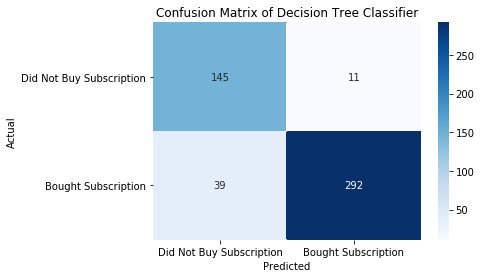

In [76]:
# calling the visual_cm function
visual_cm(true_y = y_test,
          pred_y = tree_tuned_pred,
          labels = ['Did Not Buy Subscription', 'Bought Subscription'],
          title  = 'Confusion Matrix of Decision Tree Classifier')

<strong> Observations: </strong><br>
Our model's errors (predicted that the customer was going to buy the subscription but did not, and predicted the customer was not going to buy the subscription and did) are well balanced based on our business case. <br>
<br>
In other words, our marketing expenditure for <i> Halfway There </i> is being well utilized, since our precision in which customers will subscribe is 96%.
<br> <br>
However, our marketing expenditures could be optimized since we can see 39 out of 331 customers were not predicted to buy the subscription and still bought it. If we were to better understand these customers, we could increase the total number of customer subscriptions.


***
## Conclusion

- Our best performing model was a Decision Tree with 21 features with a test score of 0.9058
- Optimal features were found using exploratory data analysis, domain knowledge and tree classifiers
- It is predicting whether or not a customer will subscribe to the new service Halfway There.
- Its precision in correctly predicting a new customer is 96%